<p style="background:#4d618d; color:white; font-size: 2.1em; text-align:center"> 
    <br><br><b> Red Wine Quality Dataset </b><br><br><br>
</p>

<p style="text-align: right;">Module 2: Data Analysis<br>
Sprint 3: Statistical Modeling<br>
Author : Renato Mariano</p>

<img src="uvas.webp" width=500>

<h1 style="color:#4d618d">Introduction </h1>

This project is based on a dataset containing physiochemical data for the red variants of the Portuguese "Vinho Verde" wine. The data is available on https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009. Due to privacy and logistic issues, no data about grape types, wine brand, wine selling price, etc. are available.

The **goal** of this project is to **create a model that predicts the quality of the wine** taking into consideration these physiochemical features. **Another model** will be created **to predict values for the level of alcohol**.

<h2 style="color:#4d618d">Library Imports and Notebook Setup </h2>

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn import metrics
from sklearn.inspection import permutation_importance

from suplement_functions import clear_barplot

In [2]:
# Notebook setup
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x) # control the amount of output digits

from IPython.core.display import HTML                       # center plots in the notebook
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

<h1 style="color:#4d618d">Data Exploration </h1>

So let's start by reading the dataset and getting some information about it.

In [3]:
winequality = pd.read_csv("winequality-red.csv")
winequality

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.400,0.700,0.000,1.900,0.076,11.000,34.000,0.998,3.510,0.560,9.400,5
1,7.800,0.880,0.000,2.600,0.098,25.000,67.000,0.997,3.200,0.680,9.800,5
2,7.800,0.760,0.040,2.300,0.092,15.000,54.000,0.997,3.260,0.650,9.800,5
3,11.200,0.280,0.560,1.900,0.075,17.000,60.000,0.998,3.160,0.580,9.800,6
4,7.400,0.700,0.000,1.900,0.076,11.000,34.000,0.998,3.510,0.560,9.400,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.200,0.600,0.080,2.000,0.090,32.000,44.000,0.995,3.450,0.580,10.500,5
1595,5.900,0.550,0.100,2.200,0.062,39.000,51.000,0.995,3.520,0.760,11.200,6
1596,6.300,0.510,0.130,2.300,0.076,29.000,40.000,0.996,3.420,0.750,11.000,6
1597,5.900,0.645,0.120,2.000,0.075,32.000,44.000,0.995,3.570,0.710,10.200,5


In [4]:
winequality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


As we see most of dataframe consists of physiochemical float parameters, only the quality is represented as integer values (categorical data).

The dataset does not possess null values.

In [5]:
winequality.describe()[1:10].T # hide the count

,mean,std,min,25%,50%,75%,max
fixed acidity,8.320,1.741,4.600,7.100,7.900,9.200,15.900
volatile acidity,0.528,0.179,0.120,0.390,0.520,0.640,1.580
citric acid,0.271,0.195,0.000,0.090,0.260,0.420,1.000
residual sugar,2.539,1.410,0.900,1.900,2.200,2.600,15.500
chlorides,0.087,0.047,0.012,0.070,0.079,0.090,0.611
free sulfur dioxide,15.875,10.460,1.000,7.000,14.000,21.000,72.000
total sulfur dioxide,46.468,32.895,6.000,22.000,38.000,62.000,289.000
density,0.997,0.002,0.990,0.996,0.997,0.998,1.004
pH,3.311,0.154,2.740,3.210,3.310,3.400,4.010
sulphates,0.658,0.170,0.330,0.550,0.620,0.730,2.000


In [7]:
winequality.duplicated().sum()

240

<h2 style="color:#4d618d">Features Visual Distribution</h2>

The numeric presentation of the statistics for these features is difficult to assimilate. Let's take a look at some boxplots to understand their distribution better.

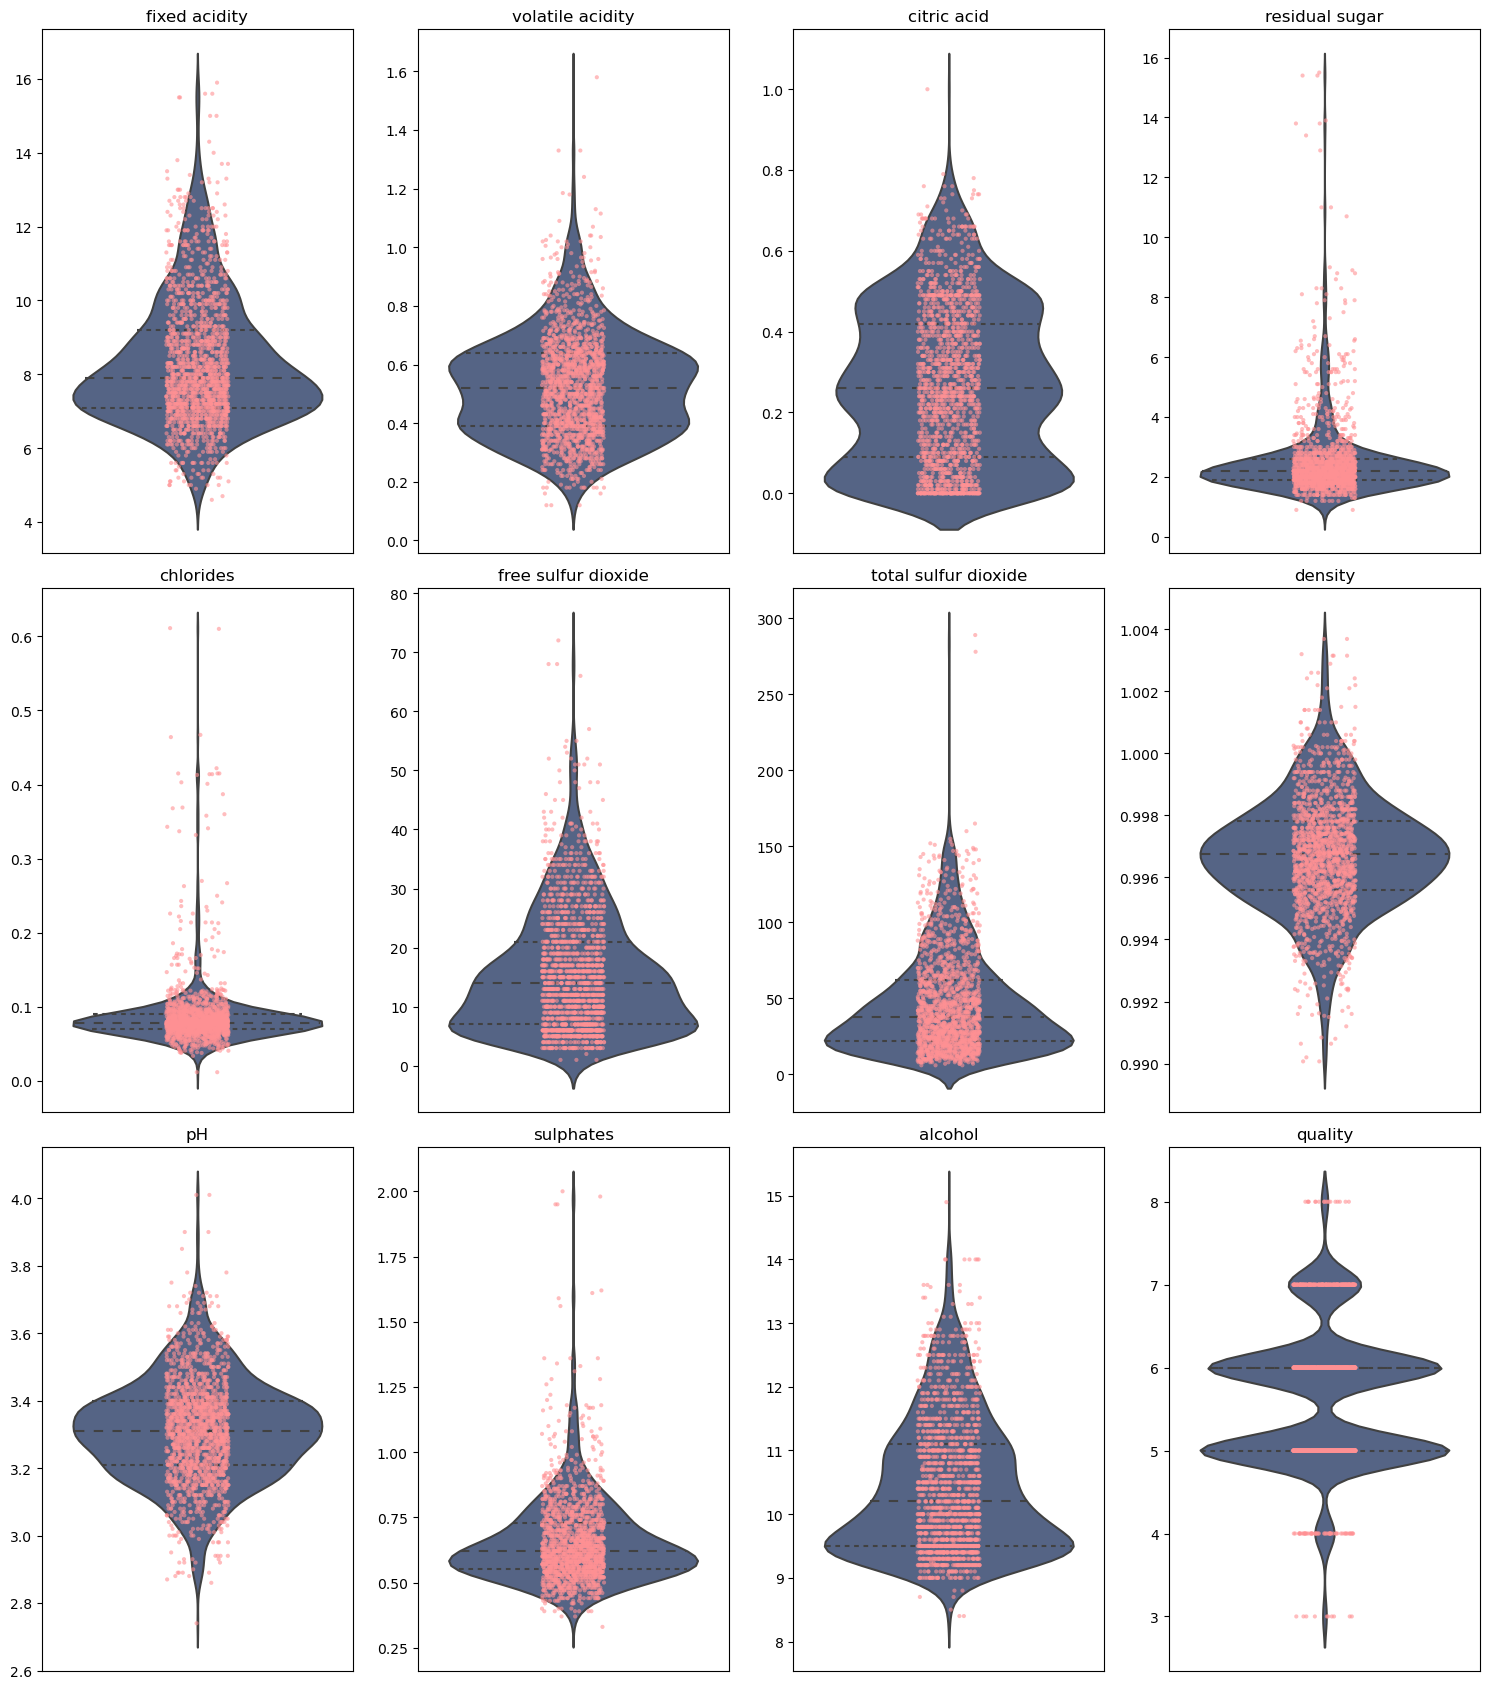

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 17))

for i, col in enumerate(winequality.columns):
    sns.violinplot(
        data=winequality[col], ax=axes[i // 4, i % 4], inner="quartile", color="#4d618d"
    )
    sns.stripplot(
        y=winequality[col], ax=axes[i // 4, i % 4], size=3, color="#ff9194", alpha=0.6
    )
    axes[i // 4, i % 4].set(title=col, ylabel="")
    axes[i // 4, i % 4].set_xticklabels([])
    axes[i // 4, i % 4].tick_params(axis="x", which="both", length=0)#

plt.tight_layout()

The visual representation give us an idea of the distribution and of the outliers containing in the dataset. Some features like **'chlorides' and 'residual sugar' present outliers that are very much far away from the median**.

In the boxplot we can also see how the **values of quality** are distributed, most values **falling into 5, 6 or 7**.

Let's numerically evaluate the **skweness of the distributions**. The calculation is made subtracting the mode from a mean and then dividing the difference by standard deviation.

In [7]:
print("Skewness of the parameters\n")
for col in winequality:
    print(f"{col} : {winequality[col].skew():.3f}")

Skewness of the parameters

fixed acidity : 0.983
volatile acidity : 0.672
citric acid : 0.318
residual sugar : 4.541
chlorides : 5.680
free sulfur dioxide : 1.251
total sulfur dioxide : 1.516
density : 0.071
pH : 0.194
sulphates : 2.429
alcohol : 0.861
quality : 0.218


The greatest the values for the skewness the greatest the outliers in a column.

To increase the predictive power of the model an **outliers removal proceedure** is taken place. In this case, any value higher or lower than 2 interquartile ranges from the 1st and 2nd quartiles will be removed.

In [8]:
cols = ['residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'sulphates']

Q1 = winequality[cols].quantile(0.25)
Q3 = winequality[cols].quantile(0.75)
IQR = Q3 - Q1

cleaned_winequality = winequality[~((winequality[cols] < (Q1 - 2 * IQR)) | (winequality[cols] > (Q3 + 2 * IQR))).any(axis=1)]
cleaned_winequality.shape

(1361, 12)

In [9]:
print(f"The new data frame contains {cleaned_winequality.shape[0]*100/winequality.shape[0]:.1f}% of the original")

The new data frame contains 85.1% of the original


In [10]:
print("Skewness of the parameters after outliers removal\n")
for col in cleaned_winequality:
    print(f"{col} : {cleaned_winequality[col].skew():.3f}")

Skewness of the parameters after outliers removal

fixed acidity : 0.924
volatile acidity : 0.533
citric acid : 0.336
residual sugar : 0.940
chlorides : 0.259
free sulfur dioxide : 0.888
total sulfur dioxide : 1.108
density : -0.088
pH : 0.305
sulphates : 0.737
alcohol : 0.863
quality : 0.307


Most of the features present a skewness bellow 1, exception to 'total sulfur dioxide'.

We can take a look at their distribution again for the visual representation.

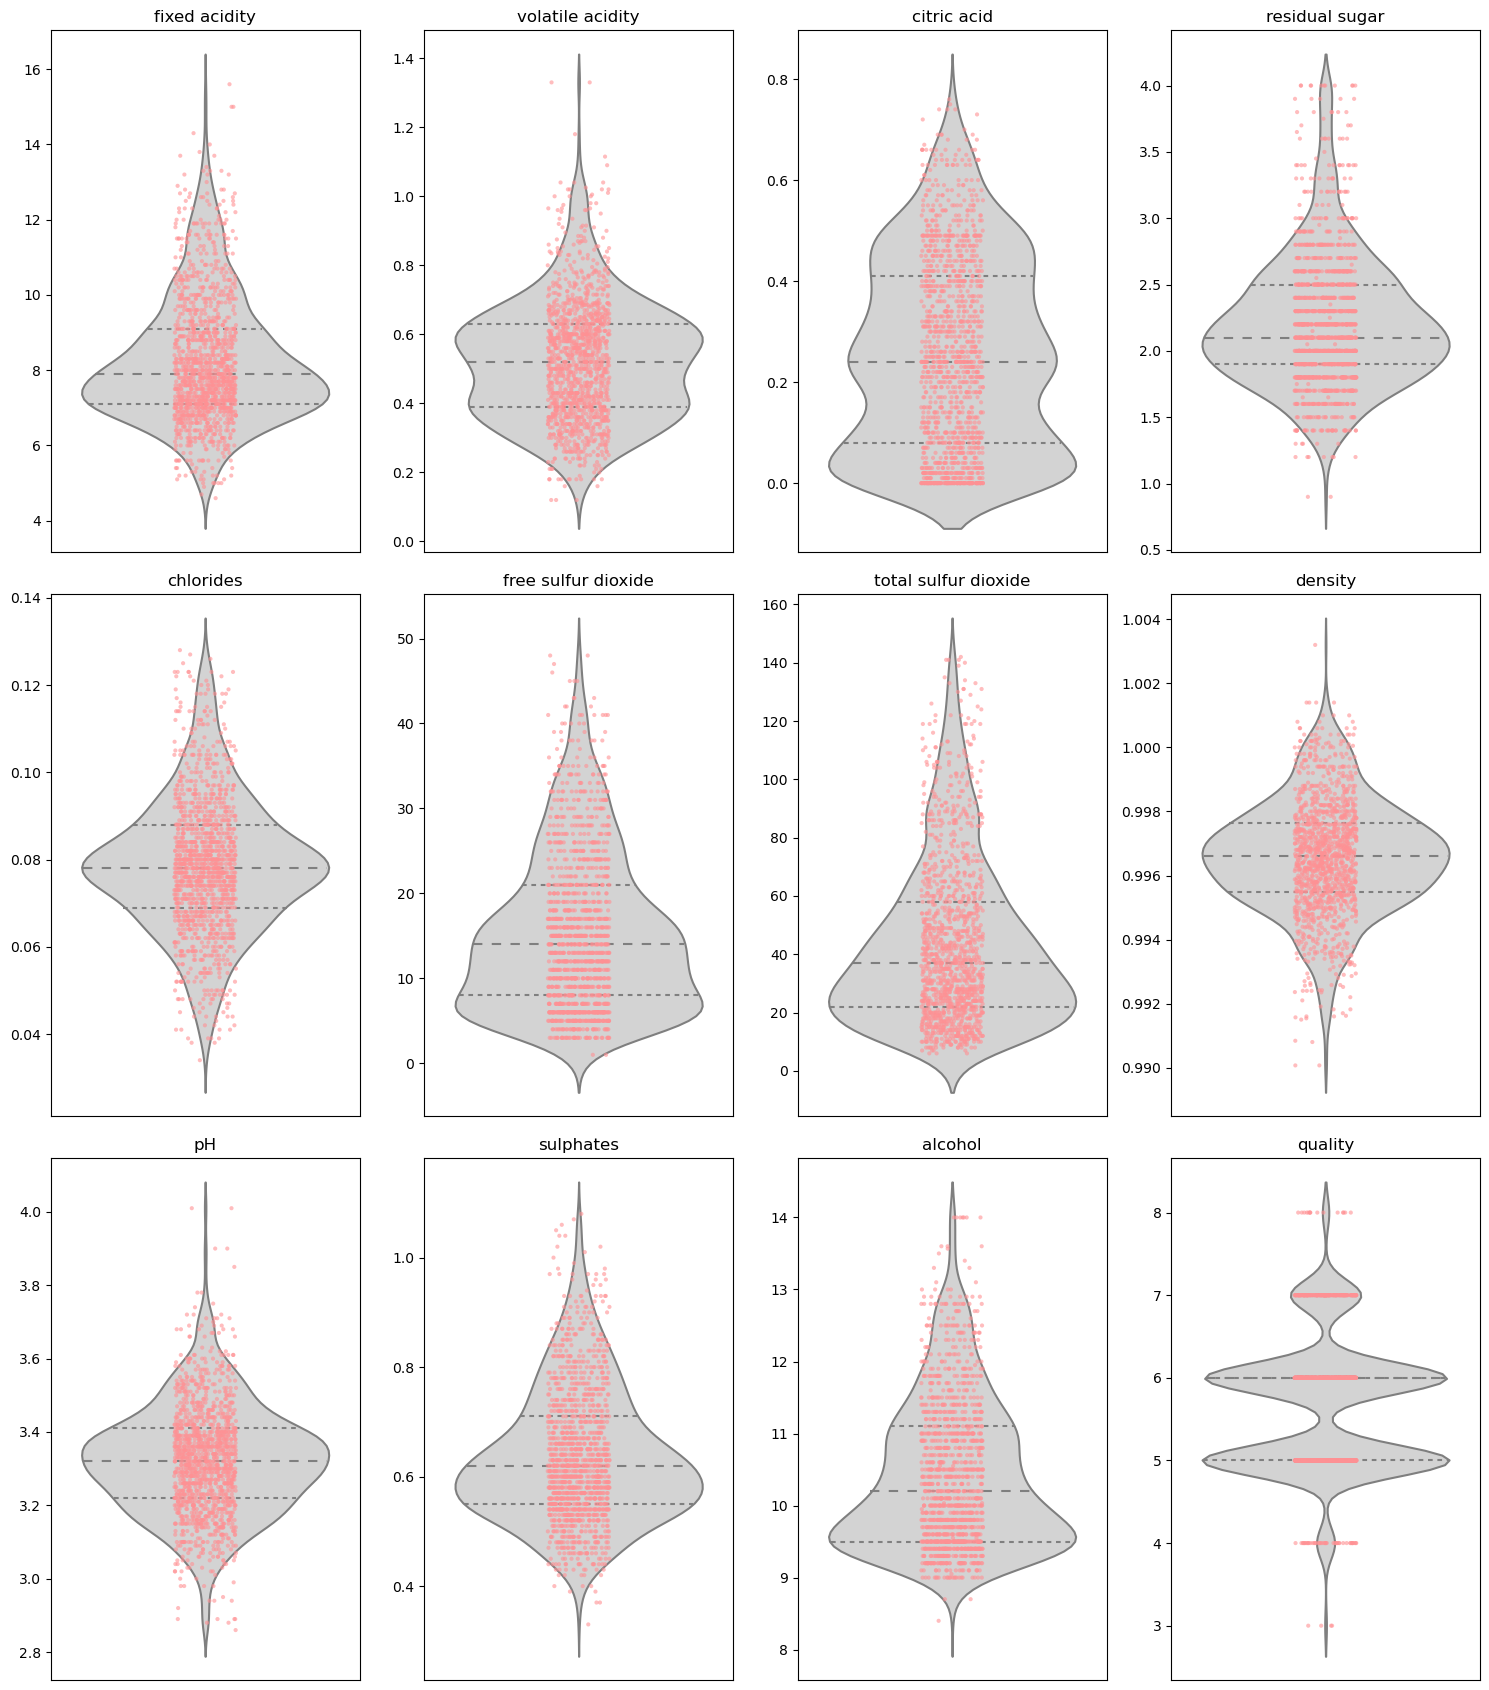

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 17))

for i, col in enumerate(winequality.columns):
    sns.violinplot(
        data=cleaned_winequality[col], ax=axes[i // 4, i % 4], inner="quartile", color="lightgrey"
    )
    sns.stripplot(
        y=cleaned_winequality[col], ax=axes[i // 4, i % 4], size=3, color="#ff9194", alpha=0.6
    )
    axes[i // 4, i % 4].set(title=col, ylabel="")
    axes[i // 4, i % 4].set_xticklabels([])
    axes[i // 4, i % 4].tick_params(axis="x", which="both", length=0)#

plt.tight_layout()

<h2 style="color:#4d618d">Features Correlation</h2>

Let's take a look if these features correlate to each other. Strictly saying the wine quality is a category, so it will not be placed in the following heatmap.

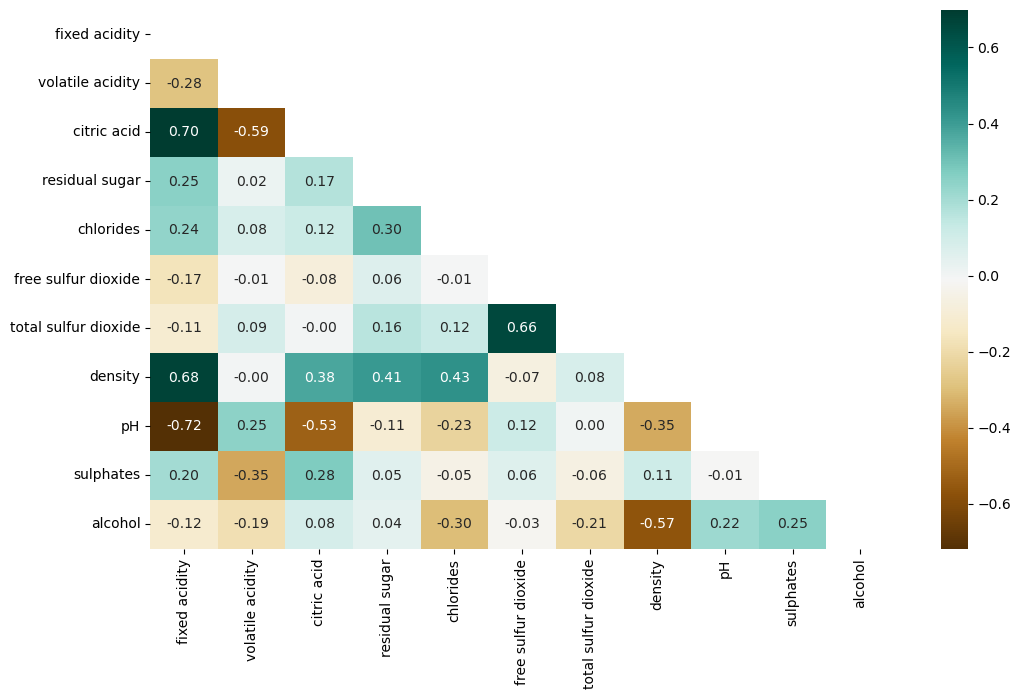

In [12]:
matrix = np.triu(cleaned_winequality.iloc[:,0:11].corr()) # returns the Upper triangle of an array

plt.figure(figsize=(12, 7))
sns.heatmap(cleaned_winequality.iloc[:,0:11].corr(), annot=True, cmap="BrBG", mask=matrix, fmt=".2f");

The map shows that the most correlated features have similar properties / names, i.e. the acidity properties, the sufur dioxides. 

Moreover, density and pH are also very correlated to fixed acidity.

<h1 style="color:#4d618d">Quality Model Selection and Steps </h1>

As shown on the violinplot, the quality of the wines is mostly medium. Let's take a look at the quantity for each category.

<h2 style="color:#4d618d">Quality Categorization</h2>

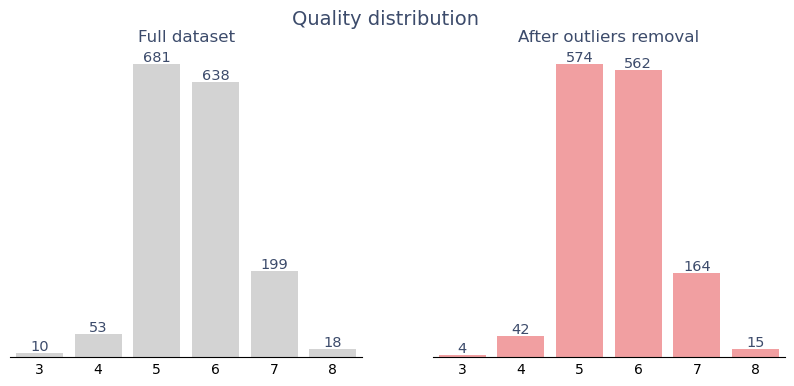

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

sns.countplot(winequality['quality'], color="lightgrey", ax=ax1)
sns.countplot(cleaned_winequality['quality'], color="#ff9194", ax=ax2,)

clear_barplot(ax1, pad_top=0)
clear_barplot(ax2, pad_top=0)

fig.suptitle("Quality distribution\n\n\n", color="#3c4b6b", fontsize=14)
ax1.set_title("Full dataset", color="#3c4b6b", fontsize=12)
ax2.set_title("After outliers removal", color="#3c4b6b", fontsize=12);

Outliers were found in all of the categories.

After the removal of them, the second step for our model will be the implementation of 3 wine quality categories. As follows:

- 3 - 4 --> (1) Bad 
- 5 - 6 --> (2) Average 
- 7 - 8 --> (3) Good 

In [14]:
# Mapping of the categories
mapping = {3: 1, 4: 1, 5: 2, 6: 2, 7: 3, 8: 3}
cleaned_winequality["Quality Category"] = cleaned_winequality["quality"].map(mapping)

# Percentage of wines in each category
cleaned_winequality.groupby(
    cleaned_winequality["Quality Category"]
).size() * 100 / cleaned_winequality.groupby(
    cleaned_winequality["Quality Category"]
).size().sum()

Quality Category
1    3.380
2   83.468
3   13.152
dtype: float64

In [15]:
cleaned_winequality.groupby(
    cleaned_winequality["Quality Category"]
).size()

Quality Category
1      46
2    1136
3     179
dtype: int64

Only 3% of the wines belong to the category 1 (Bad) and 13% to the category 3(Good).

<h2 style="color:#4d618d">Definition of the model</h2>

Let's start by **separating the categorical data from the numerical**, and then separating the **train and test data**.

**70% of the data will be used to train** the model and 30 % to test it. The used random_state was the 99.

The next step is to scale the numerical features so that they have a mean of 0 and a standard deviation of 1 using StandardScaler.

In [16]:
X = cleaned_winequality.drop(['quality', 'Quality Category'], axis=1)
y = cleaned_winequality['Quality Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=99) 

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)    # fit the train data 
X_test_scaled = scaler.transform(X_test)          # applies this transformation to the test data

Due to the categorial nature of the dependent variable (Multinomial variable) we will be carring out a logistic regression model.

In [18]:
#Train a logistic regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

LogisticRegression()

<h2 style="color:#4d618d">Model Performance</h2>

In [19]:
#Make predictions on the test set
y_pred = model.predict(X_test_scaled)

#Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Accuracy: 0.8117359413202934
Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        15
           2       0.86      0.93      0.89       339
           3       0.41      0.31      0.35        55

    accuracy                           0.81       409
   macro avg       0.42      0.41      0.42       409
weighted avg       0.77      0.81      0.79       409



Our model predicted the right category 81% of the time.

From the precision reuslts, we can see already that the model could not predict wines for category 1 (Bad).

Let's see the results of the confusion matrix.

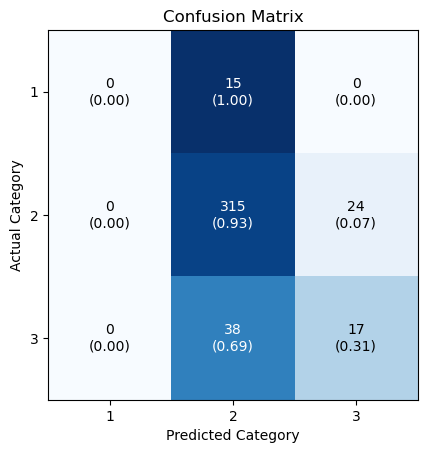

In [20]:
cm = metrics.confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=False)

plt.xticks(np.arange(3), ["1", "2", "3"])
plt.yticks(np.arange(3), ["1", "2", "3"])

ax.set(ylabel="Actual Category", xlabel="Predicted Category", title="Confusion Matrix",);

As stated previously, the model could not predict any values for category 1 (Bad).
This can occur in part because most of our data is centered in the middle class, only 3% of the data is in category 1.

For the category 3 (Good), the predictive power is also not ideal, out of the 41 values predicted for this class only 17 were a true positive (31%).

In order to evaluate the **importance of each feature in our model**, we will run the permutation importance.

**This measures how much the performance of the model drops by the removal of each feature.**

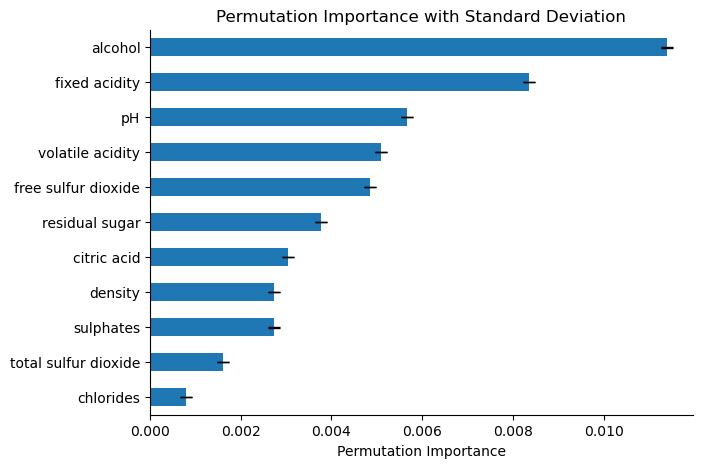

In [21]:
result = permutation_importance(model, X_test_scaled, y_test, n_repeats=50, random_state=99)

feature_importance = pd.DataFrame(
    {
        "Feature": X.columns,
        "Importance": result.importances_mean,
        "Standard Deviation": result.importances_std,
    }
)
mask = feature_importance['Importance']<0
feature_importance['Importance'][mask] = feature_importance['Importance'][mask] * -1
feature_importance = feature_importance.sort_values("Importance", ascending=True)


ax = feature_importance.plot(
    x="Feature",
    y="Importance",
    kind="barh",
    color="tab:blue",
    figsize=(7, 5),
    yerr="Standard Deviation",
    capsize=4,
)

sns.despine()
ax.set(
    ylabel="",
    xlabel="Permutation Importance",
    title="Permutation Importance with Standard Deviation",
)
ax.legend([], frameon=False);

Some of the features don't seem to have much influence on the model's performance.

In order to make a cleaner model, that will be easier to evaluate, these features will be removed (chlorides, total sulfur dioxide, sulfates and density and citric acid).

As the "pH" is highly negatively correlated to the fixed acidity, we will also be dropping this column from our model.

<h1 style="color:#4d618d">Cleaned Quality Model </h1>

Let's first define our train and test data and our model.

In [22]:
X = cleaned_winequality.drop(
    [
        "quality",
        "Quality Category",
        "chlorides",
        "total sulfur dioxide",
        "sulphates",
        "density",
        "citric acid",
        "pH",
        
    ],
    axis=1,
)
y = cleaned_winequality["Quality Category"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=99)

# Scale the feature data using StandardScaler:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Train a logistic regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

LogisticRegression()

In [23]:
#Make predictions on the test set
y_pred = model.predict(X_test_scaled)

#Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Accuracy: 0.8117359413202934
Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        15
           2       0.85      0.94      0.89       339
           3       0.40      0.25      0.31        55

    accuracy                           0.81       409
   macro avg       0.42      0.40      0.40       409
weighted avg       0.76      0.81      0.78       409



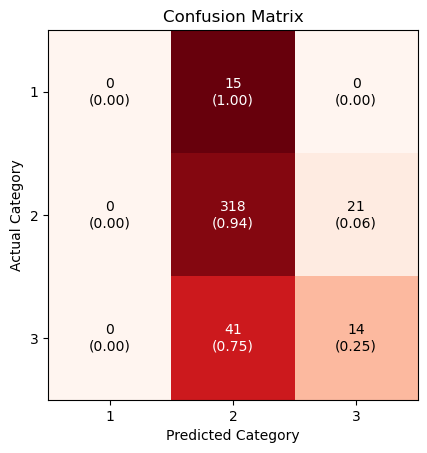

In [24]:
cm = metrics.confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=False,
                                cmap='Reds')

plt.xticks(np.arange(3), ["1", "2", "3"])
plt.yticks(np.arange(3), ["1", "2", "3"])
ax.set(ylabel="Actual Category", xlabel="Predicted Category", title="Confusion Matrix",);

The prediction power of the model is maintained by 82% of the time 8only slightly increased).

And the confusion matrix also provide the similar values. 

This indicates that the removed features really don't have a great influence on the models' output and leads to a simplification of the model (**Simple is better than complex!**).

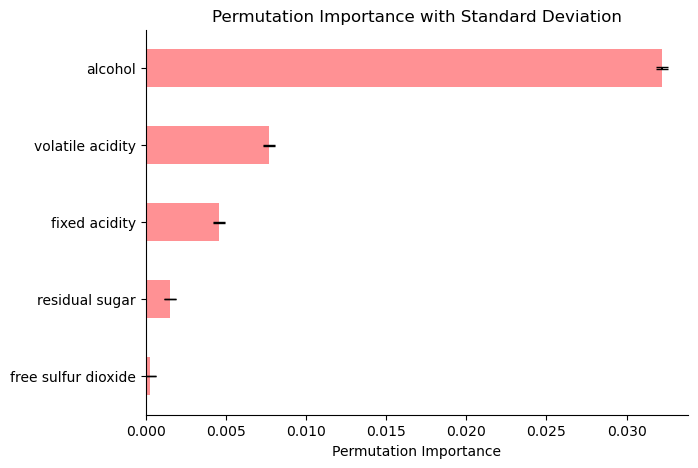

In [25]:
result = permutation_importance(model, X_test_scaled, y_test, n_repeats=50, random_state=99)

feature_importance = pd.DataFrame(
    {
        "Feature": X.columns,
        "Importance": result.importances_mean,
        "Standard Deviation": result.importances_std,
    }
)
mask = feature_importance['Importance']<0
feature_importance['Importance'][mask] = feature_importance['Importance'][mask] * -1
feature_importance = feature_importance.sort_values("Importance", ascending=True)

ax = feature_importance.plot(
    x="Feature",
    y="Importance",
    kind="barh",
    color="#ff9194",
    figsize=(7, 5),
    yerr="Standard Deviation",
    capsize=4,
)

sns.despine()
ax.set(
    ylabel="",
    xlabel="Permutation Importance",
    title="Permutation Importance with Standard Deviation",
)
ax.legend([], frameon=False);

We can see that the distribution of importance seem to change, volatile acidity occupies now a higher importance than the fixed one. Besides the importance of free sulfur dioxide and residual sugar seem to have decreased.

Another result of this observation can be that the model is not presenting changes in prediction due to the fact that the data is very much concentrated in category 2 (Average).

<h1 style="color:#4d618d">Statistical Inference </h1>

As the feature alcohol seems to be very important for the model. It would be interesting to evaluate if there is a statistical difference between the mean alcohol levels towards the categories.

Before moving on to the that, let's take a look at some of the statistics for the percentage of alcohol in each category.

In [26]:
stats_alcohol = cleaned_winequality.groupby('Quality Category')['alcohol'].agg(['count', 'mean', 'median', 'std']).reset_index()
stats_alcohol

,Quality Category,count,mean,median,std
0,1,46,10.204,10.000,0.882
1,2,1136,10.263,10.000,0.946
2,3,179,11.525,11.500,1.006


We see that there is a **tendency for better wines to contain a higher level of alcohol**. Is it statistically significant?

Due to the amount of data available, **let's first evaluate for the Average (2) and Good (3) Categories.**

<h2 style="color:#4d618d">Hypothesis Testing 1</h2>

* Category 2:`'Average'`
* Category 3:`'Good'`

$$H_0: p_2 = p_3$$
$$H_a: p_2 \ne p_3$$

where $p_2$ and $p_3$ stand for the average alcohol level for the wine categories 2 and 3, respectively. We'll also set a **confidence level of 95%**:

$$\alpha = 0.05$$

The $\alpha$ value is a threshold we set, by which we say "if the probability of observing a result as extreme or more ($p$-value) is lower than $\alpha$, then we reject the null hypothesis". Since our $\alpha=0.05$ (indicating 5% probability), our confidence (1 - $\alpha$) is 95%.


As our alcohol data is continuous and the sample sizes are not so big, we will perform a **t-test** to check our hypothesis.

In [27]:
quality2 = cleaned_winequality[cleaned_winequality['Quality Category'] == 2]['alcohol']
quality3 = cleaned_winequality[cleaned_winequality['Quality Category'] == 3]['alcohol']

t_stat, p_value = ttest_ind(quality2, quality3)
print(t_stat,"\n\np-value:", p_value)

-16.45261682256886 

p-value: 1.9156342288041875e-55


$$p-value \approx 0.00    <   \alpha = 0.05$$

That means that for out confidence interval of 95% we have enough evidence to reject the null hypothesis ($H_0$).

So **the mean of the average alcohol level for the Good and Average categories is statistically different**.

Practically we see that the **Good Category of wines present a higher level of alcohol**.

<h2 style="color:#4d618d">Hypothesis Testing 2</h2>

* Category 1:`'Bad'`
* Category 2:`'Average'`

As observed before, the mean values for these 2 categories is not so far apart and they intersect in their interquartile range (taking into consideration their standard deviation). We should not expect that the statistics would provide us with a very different result. Let's perform the **t-test** again to evaluate these results.

$$H_0: p_1 = p_2$$
$$H_a: p_1 \ne p_2$$
$$\alpha = 0.05$$

In [28]:
quality1 = cleaned_winequality[cleaned_winequality['Quality Category'] == 1]['alcohol']

t_stat, p_value = ttest_ind(quality1, quality2)
print(t_stat,"\n\np-value:", p_value)

-0.41160305256023927 

p-value: 0.6807051427220667


$$p-value = 0.06    >   \alpha = 0.05$$

That means that for out confidence interval of 95% we **do not have enough evidence** to reject the null hypothesis ($H_0$).

So **the mean of the average alcohol level for the Bad and Average categories is statistically equal**.

<h1 style="color:#4d618d">Alcohol Model </h1>

Let's start this model by taking a look again at the distribution of alchool and how it correlates to other features.

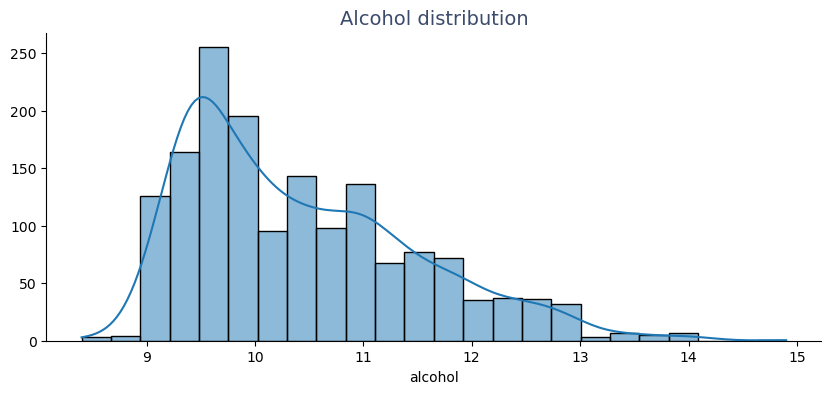

In [29]:
fig, ax1 = plt.subplots(figsize=(10, 4))

sns.histplot(winequality['alcohol'], color="tab:blue", kde=True, ax=ax1)

ax1.set_title("Alcohol distribution", color="#3c4b6b", fontsize=14)
sns.despine()
ax1.set(ylabel="");

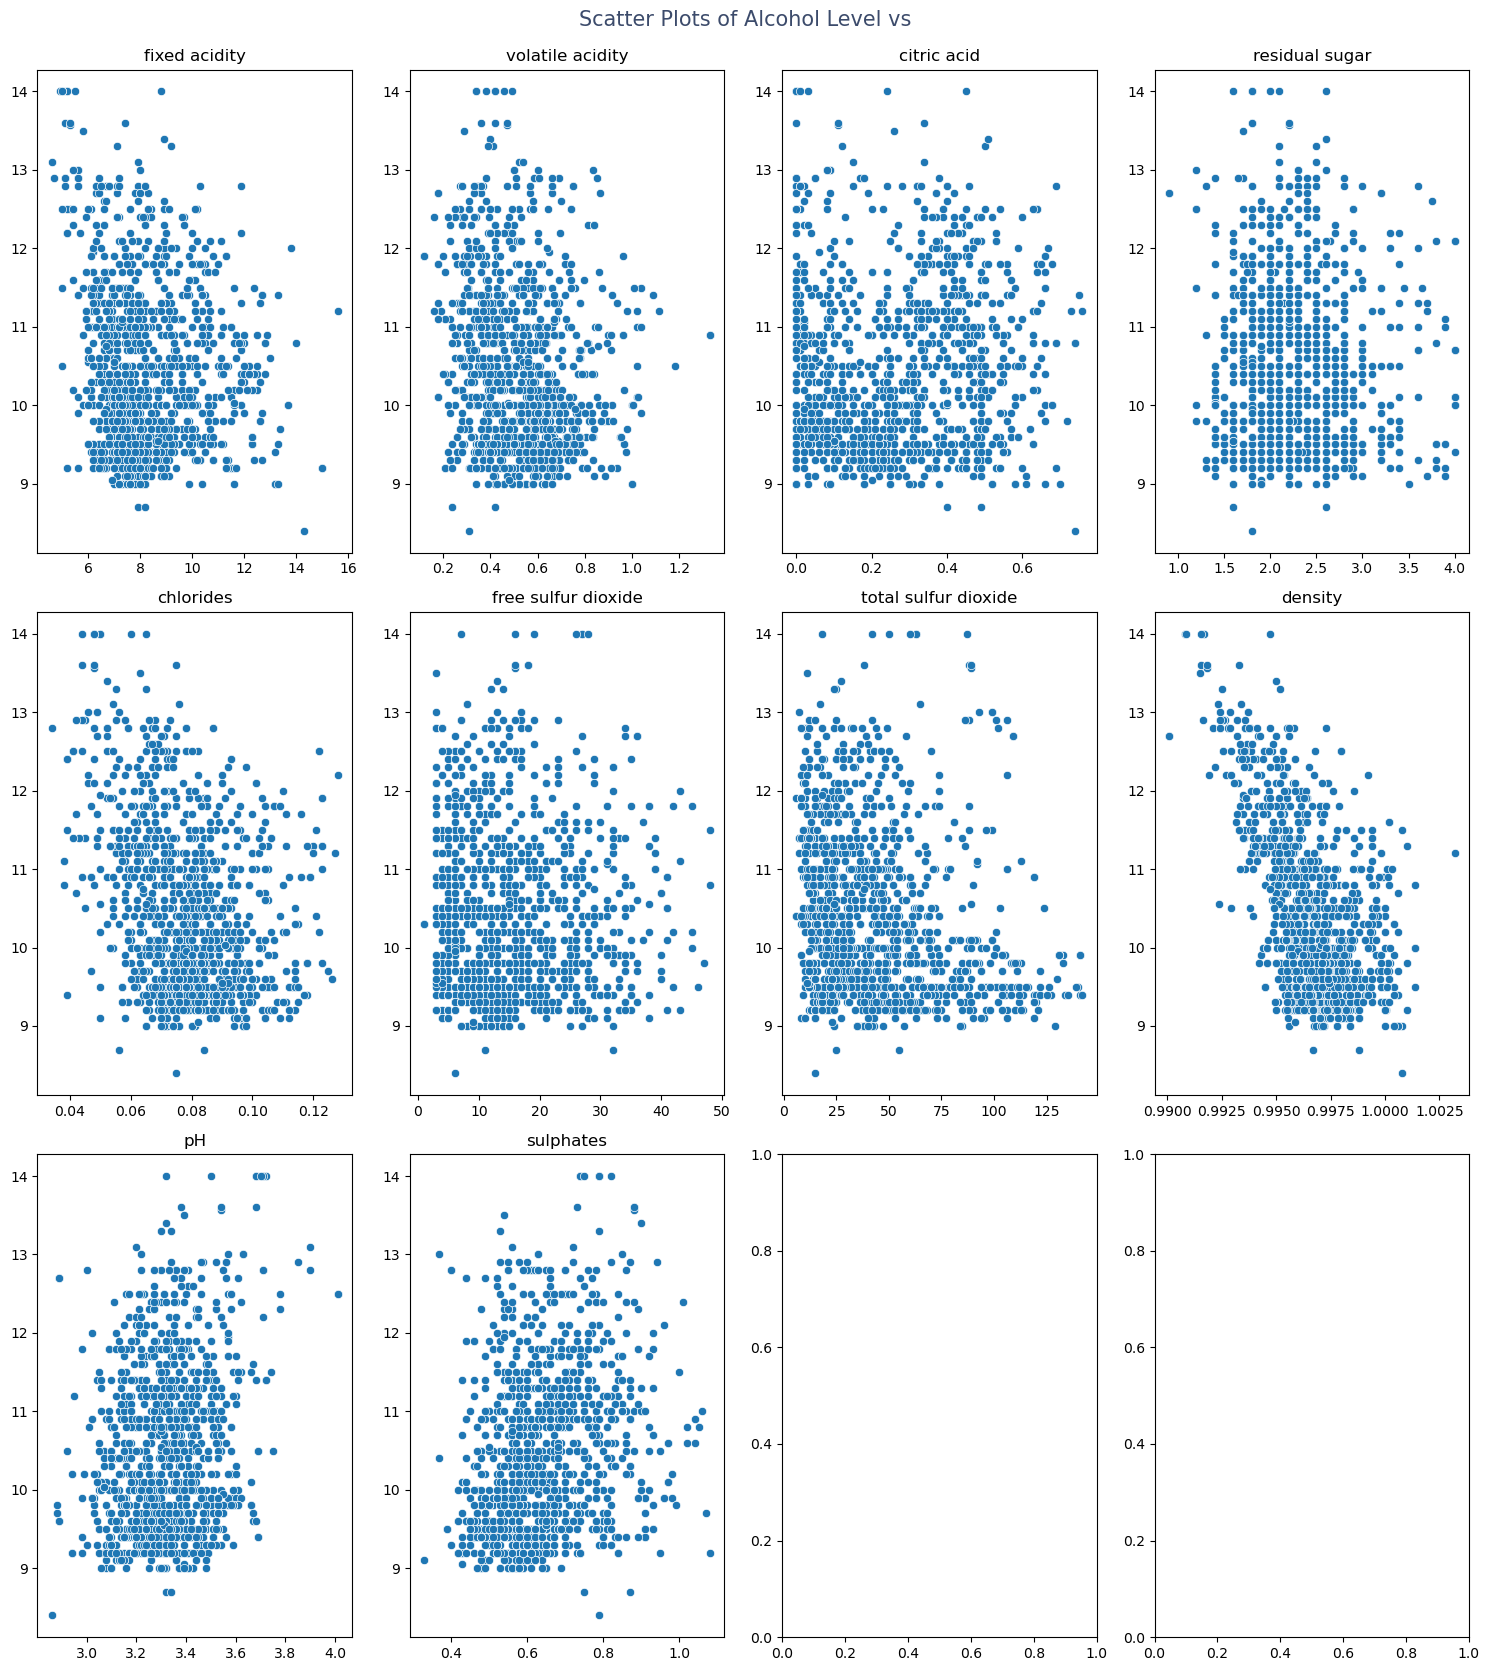

In [30]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 17))

for i, col in enumerate(cleaned_winequality.drop(["quality", "Quality Category", "alcohol"], axis=1).columns):
    sns.scatterplot(x=cleaned_winequality[col], y=cleaned_winequality["alcohol"], ax=axes[i // 4, i % 4], color="tab:blue")
    axes[i // 4, i % 4].set(title=col, ylabel="", xlabel="")

fig.suptitle("Scatter Plots of Alcohol Level vs\n", color="#3c4b6b", fontsize=15)
plt.tight_layout();

We see that there is a clear negative correlation with density and chlorides. For this model we will again use all the features (exception to quality). In this case to predict the alcohol level of the wine.

**We will be fitting a multilinear model to our data**.

The same model choices were made here. 70% and same random state.

In [31]:
X = cleaned_winequality.drop(["quality", "Quality Category", "alcohol"], axis=1)
y = cleaned_winequality["alcohol"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=99)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
mse = metrics.mean_squared_error(y_test, y_pred)
mae = metrics.mean_absolute_error(y_test, y_pred)
r2 =metrics.r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared Score:", r2)

Mean Squared Error: 0.3090952942339852
Mean Absolute Error: 0.4177915827564643
R-squared Score: 0.7244514862109207


72% of the variance in the alcohol levels can be explained by the model. 

Besides, the mean squared error (MSE) of 0.3 seems like a good fit for the range of alcohol data; it measures the average squared difference between the predicted and actual values for the alcohol levels.

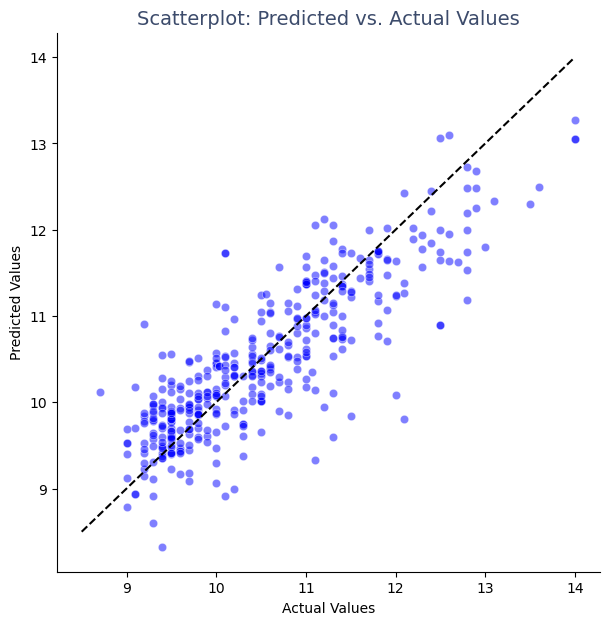

In [32]:
fig, ax1 = plt.subplots(figsize=(7, 7))
sns.scatterplot(x=y_test, y=y_pred, color='blue', alpha=0.5, ax=ax1)

sns.despine()
ax1.set_title("Scatterplot: Predicted vs. Actual Values", color="#3c4b6b", fontsize=14)
ax1.set(xlabel='Actual Values', ylabel="Predicted Values");

plt.plot((8.5, 14), (8.5, 14), 'k--');

Through this Scatterplot evaluation, we can see that most of the predicted points are not so far away from the line (45° line), so the predictive power of the model seems to be good.

<h1 style="color:#4d618d">Conclusion </h1>

The final **model for the wine categories** shows an accuracy of 82%, which sounds like a good value, but effectively categorize wines mostly as average.

The refered model could not predict a wine in the Category 1 (Bad) and had an accuracy of 31% for the Category 3 (Good).

Model **improvements** could maybe be obtained through the use of other model types (i.e. Decision Tree Classifier, Random Forest Classifier). The use of the whole dataset without outliers removal should also be evaluated.

As the data is very concentrated in the middle category it's hard to expect better outputs from a model trained on this data.


The **statistical inference analysis** highlighted that a **high level of alcohol is an important parameter** for a wine to be considered good.

Besides, **the model created to predict the alcohol level** seems based on other physiochemical features seemed to **behave very well**, having 72% of its variance explained by the model.
